In [1]:
import pandas as pd
from abc import ABC, abstractmethod
import nbimporter
from train import get_cryptoquant_data
import numpy as np
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator, StochasticOscillator, WilliamsRIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from ta.momentum import ROCIndicator

pd.set_option('display.max_rows', None)

In [2]:
class ISignalGeneration(ABC):
    @abstractmethod
    def strategic(self, cryptoquant_data):
        pass

In [3]:
class SignalRegen(ISignalGeneration):
    def strategic(self, data):
        # --- RSI (14-period) ---
        rsi = RSIIndicator(close=data['close'], window=14)
        data['rsi'] = rsi.rsi()

        # --- Stochastic Oscillator (14,3,3) ---
        stoch = StochasticOscillator(high=data['high'], low=data['low'], close=data['close'], window=14, smooth_window=3)
        data['stoch_k'] = stoch.stoch()
        data['stoch_d'] = stoch.stoch_signal()

        # --- MACD (12,26,9) ---
        macd = MACD(close=data['close'], window_slow=26, window_fast=12, window_sign=9)
        data['macd'] = macd.macd()
        data['macd_signal'] = macd.macd_signal()
        data['macd_hist'] = macd.macd_diff()

        # --- Bollinger Bands (20,2) ---
        bb = BollingerBands(close=data['close'], window=20, window_dev=2)
        data['bb_upper'] = bb.bollinger_hband()
        data['bb_lower'] = bb.bollinger_lband()
        data['bb_middle'] = bb.bollinger_mavg()

        # --- Momentum (10-period Rate of Change) ---
        momentum = ROCIndicator(close=data['close'], window=10)
        data['momentum'] = momentum.roc()

        return data 


In [4]:
def get_signal_generation():
    data = get_cryptoquant_data()
    data = SignalRegen().strategic(data)

    return data

In [5]:
data = get_signal_generation()
print(data.head())

                        close      high       low      open        volume  \
datetime                                                                    
2019-04-13 18:00:00  0.325356  0.326071  0.323801  0.324167  1.182091e+06   
2019-04-13 19:00:00  0.323758  0.327372  0.323867  0.324229  1.666154e+06   
2019-04-13 20:00:00  0.323968  0.326282  0.323435  0.324305  1.638024e+06   
2019-04-13 21:00:00  0.325010  0.326104  0.322575  0.326092  2.831295e+06   
2019-04-13 22:00:00  0.326195  0.327429  0.324122  0.325016  1.593896e+06   

                     rsi  stoch_k  stoch_d  macd  macd_signal  macd_hist  \
datetime                                                                   
2019-04-13 18:00:00  NaN      NaN      NaN   NaN          NaN        NaN   
2019-04-13 19:00:00  NaN      NaN      NaN   NaN          NaN        NaN   
2019-04-13 20:00:00  NaN      NaN      NaN   NaN          NaN        NaN   
2019-04-13 21:00:00  NaN      NaN      NaN   NaN          NaN        NaN   
2019

In [6]:
data = get_signal_generation()

print(data.head(10))

data['rsi_signal'] = 0
data.loc[data['rsi'] < 30, 'rsi_signal'] = 1  # Buy if RSI < 30 (oversold)
data.loc[data['rsi'] > 70, 'rsi_signal'] = -1  # Sell if RSI > 70 (overbought)

data['stoch_signal'] = 0
data.loc[(data['stoch_k'] > data['stoch_d']) & (data['stoch_k'] < 20), 'stoch_signal'] = 1  # Bullish crossover in oversold
data.loc[(data['stoch_k'] < data['stoch_d']) & (data['stoch_k'] > 80), 'stoch_signal'] = -1  # Bearish crossover in overbought

data['macd_signal'] = 0
data.loc[data['macd'] > data['macd_signal'], 'macd_signal'] = 1  # MACD line above signal line
data.loc[data['macd'] < data['macd_signal'], 'macd_signal'] = -1

data['bb_signal'] = 0
data.loc[data['close'] <= data['bb_lower'], 'bb_signal'] = 1  # Buy if price touches lower band
data.loc[data['close'] >= data['bb_upper'], 'bb_signal'] = -1  # Sell if price touches upper band

data['momentum_signal'] = 0
data.loc[data['momentum'] > 0, 'momentum_signal'] = 1  # Buy if momentum is positive
data.loc[data['momentum'] < 0, 'momentum_signal'] = -1


                        close      high       low      open        volume  \
datetime                                                                    
2019-04-13 18:00:00  0.325356  0.326071  0.323801  0.324167  1.182091e+06   
2019-04-13 19:00:00  0.323758  0.327372  0.323867  0.324229  1.666154e+06   
2019-04-13 20:00:00  0.323968  0.326282  0.323435  0.324305  1.638024e+06   
2019-04-13 21:00:00  0.325010  0.326104  0.322575  0.326092  2.831295e+06   
2019-04-13 22:00:00  0.326195  0.327429  0.324122  0.325016  1.593896e+06   
2019-04-13 23:00:00  0.325087  0.328675  0.324989  0.326644  1.428759e+06   
2019-04-14 00:00:00  0.326876  0.328779  0.324642  0.324642  1.201864e+06   
2019-04-14 01:00:00  0.329464  0.330505  0.325937  0.326576  3.791895e+06   
2019-04-14 02:00:00  0.325129  0.328794  0.324734  0.327834  2.390760e+06   
2019-04-14 03:00:00  0.325212  0.327547  0.323980  0.325269  2.035724e+06   

                     rsi  stoch_k  stoch_d  macd  macd_signal  macd_hist  \

In [7]:
# Buy condition: At least 2 indicators are +1 (Buy)
buy_condition = (
    (data["rsi_signal"] == 1).astype(int) +
    (data["stoch_signal"] == 1).astype(int) +
    (data["macd_signal"] == 1).astype(int) +
    (data["bb_signal"] == 1).astype(int) +
    (data["momentum_signal"] == 1).astype(int)
) >= 2

# Sell condition: At least 3 indicators are -1 (Sell)
sell_condition = (
    (data["rsi_signal"] == -1).astype(int) +
    (data["stoch_signal"] == -1).astype(int) +
    (data["macd_signal"] == -1).astype(int) +
    (data["bb_signal"] == -1).astype(int) +
    (data["momentum_signal"] == -1).astype(int)
) >= 3

# Assign final signals
data["final_signal"] = 0
data.loc[buy_condition, "final_signal"] = 1    
data.loc[sell_condition, "final_signal"] = -1  

trade_counts = data["final_signal"].value_counts()
print(f"Count of 1 (buy signal): {trade_counts.get(1, 0)}")
print(f"Count of -1 (sell signal): {trade_counts.get(-1, 0)}")
freq = ((data["final_signal"] == 1) | (data["final_signal"] == -1)).sum() / len(data)
print(f"frequency: {freq}")


Count of 1 (buy signal): 1670
Count of -1 (sell signal): 1815
frequency: 0.06630769816203051


In [8]:
print(data.head(10))

                        close      high       low      open        volume  \
datetime                                                                    
2019-04-13 18:00:00  0.325356  0.326071  0.323801  0.324167  1.182091e+06   
2019-04-13 19:00:00  0.323758  0.327372  0.323867  0.324229  1.666154e+06   
2019-04-13 20:00:00  0.323968  0.326282  0.323435  0.324305  1.638024e+06   
2019-04-13 21:00:00  0.325010  0.326104  0.322575  0.326092  2.831295e+06   
2019-04-13 22:00:00  0.326195  0.327429  0.324122  0.325016  1.593896e+06   
2019-04-13 23:00:00  0.325087  0.328675  0.324989  0.326644  1.428759e+06   
2019-04-14 00:00:00  0.326876  0.328779  0.324642  0.324642  1.201864e+06   
2019-04-14 01:00:00  0.329464  0.330505  0.325937  0.326576  3.791895e+06   
2019-04-14 02:00:00  0.325129  0.328794  0.324734  0.327834  2.390760e+06   
2019-04-14 03:00:00  0.325212  0.327547  0.323980  0.325269  2.035724e+06   

                     rsi  stoch_k  stoch_d  macd  macd_signal  macd_hist  \

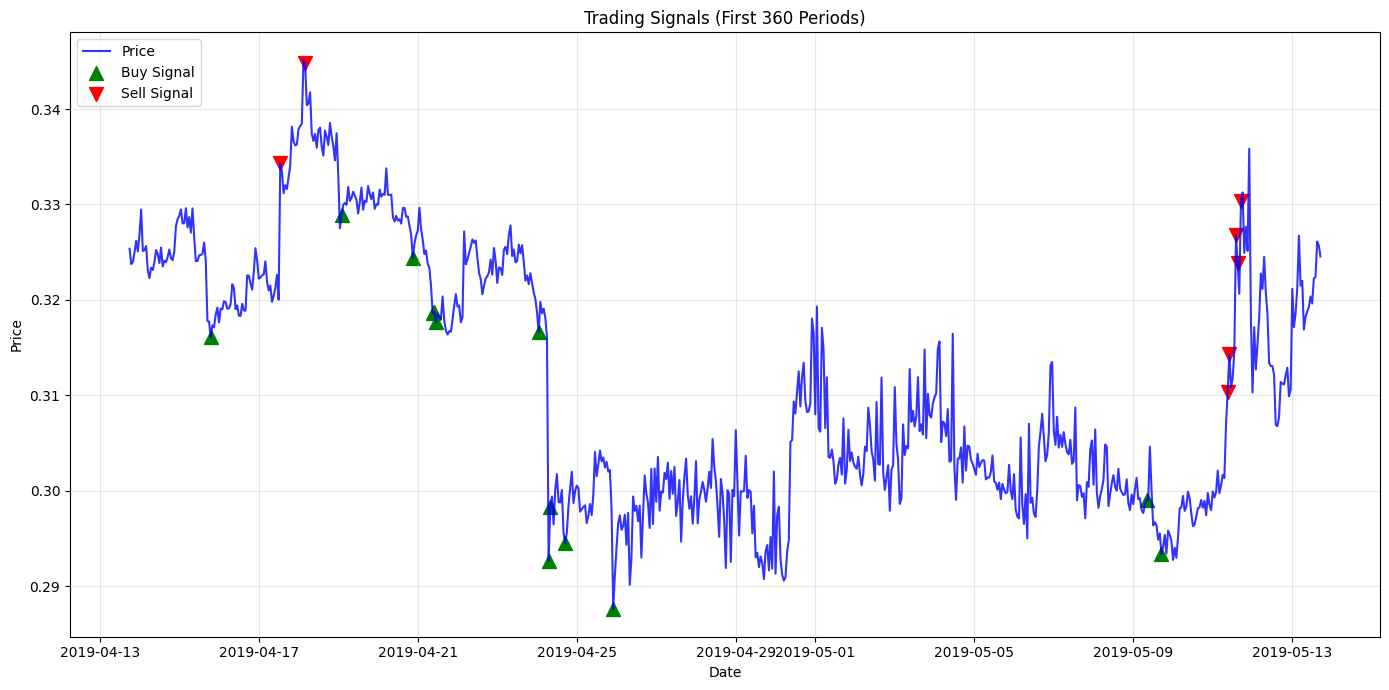

In [9]:
plt.figure(figsize=(14, 7))

plot_data = data.iloc[:720]

# Plot price line (first 360 days)
plt.plot(plot_data.index, plot_data['close'], 
         label='Price', color='blue', alpha=0.8)

# Buy signals (green arrows)
plt.scatter(
    plot_data[plot_data['final_signal'] == 1].index,
    plot_data[plot_data['final_signal'] == 1]['close'],
    color='green',
    marker='^',
    s=100,
    label='Buy Signal'
)

# Sell signals (red arrows)
plt.scatter(
    plot_data[plot_data['final_signal'] == -1].index,
    plot_data[plot_data['final_signal'] == -1]['close'],
    color='red',
    marker='v',
    s=100,
    label='Sell Signal'
)

plt.title('Trading Signals (First 360 Periods)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()  # Prevent label cutoff
plt.show()

In [10]:
# def run_backtest(data, fee_rate=0.0006):
#     """
#     Properly implemented backtest for hourly crypto trading
#     Returns: DataFrame with strategy returns and position tracking
#     """
#     df = data.copy()
#     df['position'] = 0  # Track current position (0 or 1)
#     df['trade_return'] = 0.0  # Simple returns at trade close
#     df['cumulative_return'] = 0.0  # Cumulative strategy return
#     df['equity'] = 1.0  # Starting with $1 equity
    
#     in_position = False
#     entry_price = 0.0
#     trade_count = 0
#     winning_trades = 0
    
#     for i in range(1, len(df)):
#         current_signal = df['final_signal'].iloc[i]
#         current_price = df['close'].iloc[i]
        
#         # Entry condition
#         if not in_position and current_signal == 1:
#             entry_price = current_price * (1 + fee_rate)
#             df.loc[df.index[i], 'position'] = 1
#             in_position = True
#             trade_count += 1
        
#         # Exit condition
#         elif in_position and current_signal == -1:
#             exit_price = current_price * (1 - fee_rate)
#             trade_return = (exit_price - entry_price) / entry_price
#             df.loc[df.index[i], 'trade_return'] = trade_return
#             df.loc[df.index[i], 'position'] = 0
#             in_position = False
            
#             if trade_return > 0:
#                 winning_trades += 1
    
#     # Handle final position if still open
#     if in_position:
#         exit_price = df['close'].iloc[-1] * (1 - fee_rate)
#         trade_return = (exit_price - entry_price) / entry_price
#         df.loc[df.index[-1], 'trade_return'] = trade_return
#         df.loc[df.index[-1], 'position'] = 0
#         trade_count += 1
#         if trade_return > 0:
#             winning_trades += 1
    
#     # Calculate cumulative returns
#     df['cumulative_return'] = (1 + df['trade_return']).cumprod() - 1
#     df['equity'] = (1 + df['trade_return']).cumprod()
    
#     # Calculate drawdown
#     df['peak'] = df['equity'].cummax()
#     df['drawdown'] = (df['equity'] - df['peak']) / df['peak']
    
#     return df, trade_count, winning_trades

# def calculate_performance(df, trade_count, winning_trades):
#     """Calculate all performance metrics"""
#     # Basic stats
#     active_returns = df.loc[df['trade_return'] != 0, 'trade_return']
#     win_rate = winning_trades / trade_count if trade_count > 0 else 0
#     total_gain = active_returns[active_returns > 0].sum()
#     total_loss = -active_returns[active_returns < 0].sum()  # make positive
#     profit_factor = total_gain / total_loss if total_loss != 0 else np.inf

#     # profit_factor = -active_returns[active_returns > 0].sum() / active_returns[active_returns < 0].sum() if any(active_returns < 0) else np.inf
    
#     # Annualized metrics
#     hours_per_year = 365 * 24
#     annualized_return = (1 + active_returns.mean())**hours_per_year - 1
    
#     # Use ALL periods for volatility
#     strategy_returns = df['trade_return'].fillna(0)
#     annualized_vol = strategy_returns.std() * np.sqrt(hours_per_year)
    
#     # Sharpe ratio (with hourly risk-free rate)
#     hourly_rf = 0.02 / hours_per_year
#     sharpe = ((active_returns.mean() - hourly_rf) / active_returns.std()) * np.sqrt(hours_per_year)
    
#     # Max drawdown
#     max_drawdown = df['drawdown'].min()
    
#     print(f"\n=== Strategy Performance ===")
#     print(f"Total Trades: {trade_count}")
#     print(f"Win Rate: {win_rate:.1%}")
#     print(f"Profit Factor: {profit_factor:.2f}")
#     print(f"Annualized Return: {annualized_return:.1%}")
#     print(f"Annualized Volatility: {annualized_vol:.1%}")
#     print(f"Sharpe Ratio: {sharpe:.2f}")
#     print(f"Max Drawdown: {max_drawdown:.1%}")
    
#     return {
#         'trades': trade_count,
#         'win_rate': win_rate,
#         'sharpe': sharpe,
#         'max_drawdown': max_drawdown
#     }

# # Run backtest
# results, trade_count, winning_trades = run_backtest(data)
# metrics = calculate_performance(results, trade_count, winning_trades)

In [11]:
# Calculate returns and account for transaction costs
returns = []
trade_count = 0
fee_rate = 0.0006  # 0.06%

position_storage = 0
entry_prices = []  # Store entry prices for each position
entry_times = []   # Store entry timestamps
hourly_returns = np.zeros(len(data))  # Array to store returns for each hour
cumulative_returns = np.zeros(len(data))  # Array to store cumulative returns

for i in range(len(data)):
    current_price = data['close'].iloc[i]
    signal = data['final_signal'].iloc[i]
    
    # Buy signal
    if signal == 1:
        position_storage += 1
        trade_count += 1
        entry_price = current_price * (1 + fee_rate)  # Add fee to entry price
        entry_prices.append(entry_price)
        entry_times.append(i)
    
    # Sell signal and we have positions
    elif signal == -1 and position_storage > 0:
        exit_price = current_price * (1 - fee_rate)  # Subtract fee from exit price
        
        # Process each position we're closing
        for entry_price, entry_time in zip(entry_prices, entry_times):
            # Calculate total log return for the position
            total_log_return = np.log(exit_price / entry_price)
            
            # Calculate holding period
            holding_period = i - entry_time
            if holding_period > 0:
                # Distribute the log return evenly across the holding period
                per_hour_return = total_log_return / holding_period
                hourly_returns[entry_time+1:i+1] += per_hour_return
        
        # Reset position tracking
        position_storage = 0
        entry_prices = []
        entry_times = []

# Calculate cumulative returns
cumulative_returns = np.exp(np.cumsum(hourly_returns)) - 1

# Calculate maximum drawdown
peaks = np.maximum.accumulate(cumulative_returns)
drawdowns = (cumulative_returns - peaks) / (1 + peaks)
max_drawdown = np.min(drawdowns)

# Calculate metrics
trade_frequency = trade_count / len(data)

# Calculate Sharpe Ratio (using 365 * 24 hours per year)
annual_factor = 365 * 24  # Hours in a year
risk_free_rate = 0.02  # Assuming 2% annual risk-free rate

# Use only non-zero returns for Sharpe calculation
active_returns = hourly_returns[hourly_returns != 0]
mean_hourly_return = np.mean(active_returns) if len(active_returns) > 0 else 0
std_hourly_return = np.std(active_returns) if len(active_returns) > 0 else 0
sharpe = np.sqrt(annual_factor) * (mean_hourly_return - risk_free_rate/annual_factor) / std_hourly_return if std_hourly_return > 0 else 0

print(f"Number of trades: {trade_count}")
print(f"Trading frequency (trades per hour): {trade_frequency:.4f}")
print(f"Sharpe ratio: {sharpe:.4f}")
print(f"Maximum drawdown: {max_drawdown:.4%}")

Number of trades: 1670
Trading frequency (trades per hour): 0.0318
Sharpe ratio: 3.0393
Maximum drawdown: -99.9985%
